# Tutorial 2: Firedrake + ML
#### Author: Nacime Bouziani

In [ ]:
import os
import matplotlib.pyplot as plt
import sys

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

from firedrake import *
from firedrake.adjoint import *
from firedrake.ml.pytorch import *
from firedrake.pyplot import triplot, tripcolor, streamplot

continue_annotation()

try:
  import physics_driven_ml
except:
  !git clone https://github.com/NBoulle/physics-driven-ml.git /content/physics-driven-ml
  !pip install -e /content/physics-driven-ml
  sys.path.append("/content/physics-driven-ml")
  import physics_driven_ml
#  !pip install -i https://test.pypi.org/simple/physics-driven-ml
  #import physics_driven_ml

#!git clone -b dev https://github.com/nbouziani/physics-driven-ml.git
#!pip install -e physics-driven-ml
#sys.path.append("/content/physics-driven-ml")
#import physics_driven_ml

from physics_driven_ml.dataset_processing import StokesDataset

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import Module, ModuleList, Sequential, Linear, ReLU

try:
  from torch_geometric.nn import MessagePassing
except:
  !pip install torch_geometric
  from torch_geometric.nn import MessagePassing

# Download mesh and dataset
!wget -P stokes_tutorial -c https://github.com/nbouziani/physics-driven-ml/raw/dev/data/datasets/meshes/stokes_cylinder.msh
!wget -P stokes_tutorial -c https://github.com/nbouziani/physics-driven-ml/raw/dev/data/datasets/stokes_tutorial/data.h5

--2025-03-27 12:46:52--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4601 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.49K  --.-KB/s    in 0s      

2025-03-27 12:46:52 (41.6 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4601/4601]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33

/usr/local/lib/python3.11/dist-packages/firedrake_adjoint/__init__.py:9: FutureWarning: The firedrake_adjoint module is deprecated.

Instead, use the firedrake.adjoint module and explicitly start taping
by calling continue_annotation().
  warnings.warn("""The firedrake_adjoint module is deprecated.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.6 MB/s eta 0:00:00
--2025-03-27 12:49:22--  https://github.com/nbouziani/physics-driven-ml/raw/dev/data/datasets/meshes/stokes_cylinder.msh
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nbouziani/physics-driven-ml/dev/data/datasets/meshes/stokes_cylinder.msh [following]
--2025-03-27 12:49:22--  https://raw.githubusercontent.com/nbouziani/physics-driven-ml/dev/data/datasets/meshes/stokes_cylinder.msh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62029 (61K)

In this tutorial, we employ a physics-driven ML approach that uses GNN to study the flow around a circular cylinder, a well-known test case in CFD. We consider the Stokes equations, which are a simpler version of the Navier-Stokes equations. The Stokes problem is a linear and time-independent PDE problem widely studied.

We are interested in devising a GNN model $\psi$ to learn the following operator:

$$\psi : f ↦ sol$$

where $sol := (u, p)$ is the solution of the following Stokes problem parametrised by a source term $f$:

$$
\begin{equation}
\begin{aligned}
- \Delta u + \nabla p &= f \quad \text{ on } \Omega\\
\nabla \cdot u &= 0 \quad \text{ on } \Omega
\end{aligned}
\end{equation}
$$

with $\Omega$ the domain where the problem is posed, and where $u$ and $p$ refer to the velocity field and pressure, respectively. We further equip our PDE problem with boundary conditions.

## Physical problem: flow around a circular cylinder


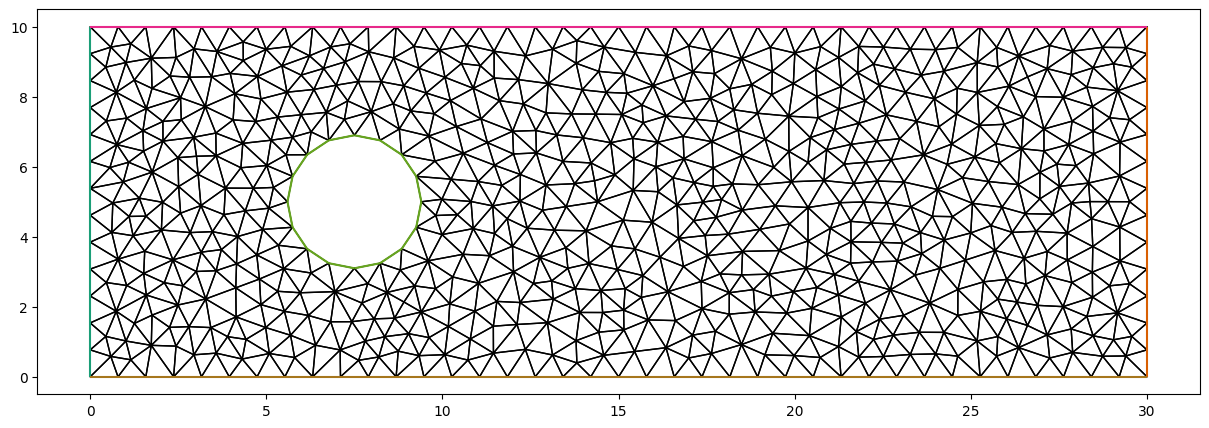

In [2]:
# Import mesh
mesh = Mesh("stokes_tutorial/stokes_cylinder.msh")

# Define mesh labels
inlet = 1
circle = 4
bottom_top = (3, 5)

# Plot mesh
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
triplot(mesh, axes=axes);

### Stokes problem

We can now define the Stokes problem using the Firedrake finite element software (Ham et al., 2023).

#### Define the PDE problem

In [3]:
# Function spaces
U = FunctionSpace(mesh, "CG", 2)
V = VectorFunctionSpace(mesh, "CG", 2)
W = FunctionSpace(mesh, "CG", 1)
Z = V * W

# Define source term
f = Function(V)

# Boundary conditions
g = Function(V).interpolate(as_vector([1., 0.]))
bcs = [DirichletBC(Z.sub(0), g, (inlet,)),
       DirichletBC(Z.sub(0), Constant((1., 0)), bottom_top),
       DirichletBC(Z.sub(0), Constant((0, 0)), (circle,))]
# Set nullspace
nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True)])

# Define solution and trial/test functions
up = Function(Z)
v, q = TestFunctions(Z)

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


In [4]:
# Solve the PDE
sol_exact = Function(Z)
u, p = TrialFunctions(Z)
a = (inner(grad(u), grad(v)) - inner(p, div(v)) + inner(div(u), q))*dx
L = inner(f, v) * dx
solve(a == L,
      sol_exact,
      bcs=bcs,
      nullspace=nullspace)

In [5]:
# Helper function to plot
def plot_sol(w):
    u, p = w.subfunctions
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    streamlines = streamplot(u, resolution=1/3, seed=0, axes=axes)
    fig.colorbar(streamlines, ax=axes, fraction=0.046)
    axes.set_title("u")

    u1, u2 = u.sub(0), u.sub(1)
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    c = tripcolor(u1, cmap="jet", axes=axes[0])
    plt.colorbar(c)
    axes[0].set_title("$u_1$")
    c = tripcolor(u2, cmap="jet", axes=axes[1])
    plt.colorbar(c)
    axes[1].set_title("$u_2$")

    c = tripcolor(p, cmap="jet", axes=axes[2])
    plt.colorbar(c)
    axes[2].set_title("p")

    plt.show()

In [ ]:
plot_sol(sol_exact)

#### Define the physical constraint

We want to incorporate physical prior knowledge into our machine learning model. For that we use the interface introduced in (Bouziani & Ham, 2023), to
incorporate a physical constraint, implemented in Firedrake, into the training loss in a similar manner than PINNs. We define that constraint as the residual form associated with the PDE.

In [15]:
# Residual assembly
def assemble_residual(sol, f):
    u, p = split(sol)
    F = (inner(grad(u), grad(v)) - inner(p, div(v)) + inner(div(u), q))*dx - inner(f, v) * dx
    return assemble(F, bcs=bcs)

In [16]:
# Define physics-driven constraint
sol = Function(Z)
f = Function(V)
with set_working_tape() as _:
    # Define PyTorch operator for assembling the residual of the PDE
    F = ReducedFunctional(assemble_residual(sol, f), [Control(sol), Control(f)])
    G = torch_operator(F)

/usr/local/lib/python3.11/dist-packages/firedrake/ml/pytorch/fem_operator.py:125: FutureWarning: `torch_operator` is deprecated, use `fem_operator` instead
  warnings.warn('`torch_operator` is deprecated, use `fem_operator` instead', FutureWarning)


## Message Passing Neural Network (MPNN)

We want to build a Graph Neural Network that follows the Encode-Process-Decode (Battaglia et al., 2018) while using a Message Passing Neural Network as processor. We first define the encoder and decoder using a single linear layer:

- Encoder:
$$
\begin{equation}
\begin{aligned}
E :\ &\mathbb{R}^{n} → \mathbb{R}^{l}\\
& x ↦ Wx + b
\end{aligned}
\end{equation}
$$

- Decoder:
$$
\begin{equation}
\begin{aligned}
D :\ &\mathbb{R}^{l} → \mathbb{R}^{m}\\
& x ↦ Wx + b
\end{aligned}
\end{equation}
$$
with $W$ and $b$ learnable parameters, and where $n$, $l$, and $m$ refer to the input, latent, and output dimensions, respectively.

In [17]:
class Encoder(Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = Linear(input_dim, latent_dim)

    def forward(self, f):
        """Apply the encoder to the input f"""
        return self.encoder(f)


class Decoder(Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = Linear(latent_dim, output_dim)

    def forward(self, h):
        """Apply the decoder to the latent feature vector h"""
        return self.decoder(h)

We now need to implement the MPNN corresponding to the processor. For this we implement a model with the following simple update rule:

$$
\begin{equation}
\begin{aligned}
  m^{n}_{ij} &= \phi_{e}(h^{n}_{i}, h^{n}_{j} - h^{n}_{i}) \\
  h^{n+1}_{i} &= \phi_{v}\left(h^{n}_{i}, \frac{1}{|N_{i}|}\sum\limits_{j \in N_{i}} m^{n}_{ij}\right)
\end{aligned}
\end{equation}
$$

where $\phi_{e}$ and $\phi_{v}$ are MLPs. For implementing this, we use the PyTorch geometric library (PyG). In a similar manner than Graph Networks, we compose several blocks of our architecture to form the processor.

In [18]:
class MPNN(MessagePassing):
    def __init__(self, input_dim, latent_dim, output_dim):
        # Set the aggregation function as the mean (permutation-invariant)
        super(MPNN, self).__init__(aggr="mean")
        # Define ϕe
        self.message_mlp = Sequential(Linear(2 * input_dim, latent_dim),
                                      ReLU(),
                                      Linear(latent_dim, latent_dim))
        # Define ϕv
        self.update_mlp = Sequential(Linear(input_dim + latent_dim, latent_dim),
                                     ReLU(),
                                     Linear(latent_dim, latent_dim // 2),
                                     ReLU(),
                                     Linear(latent_dim // 2, output_dim))

    def forward(self, h, edge_index):
        return self.propagate(edge_index, h=h)

    def message(self, h_i, h_j):
        """Compute the messages m_{ij} given the feature vectors h_{i} and h_{j}."""
        m = torch.cat([h_i, h_j - h_i], dim=-1)
        return self.message_mlp(m)

    def update(self, message, h):
        """Compute the update"""
        z = torch.cat([h, message], dim=-1)
        return self.update_mlp(z)

In [19]:
class NeuralPDESolver(Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_features, latent_features=2, nlayers=1):
        super(NeuralPDESolver, self).__init__()
        self.nlayers = nlayers
        # Encoder
        print("input_dim: %s latent_dim: %s output_dim: %s" % (num_features, latent_features, num_features))
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        # Processor
        self.processor_layers = ModuleList(modules=[MPNN(input_dim=num_features,
                                                         latent_dim=latent_features,
                                                         output_dim=num_features)
                                                    for _ in range(self.nlayers)])
        # Decoder
        self.decoder = Decoder(latent_dim=latent_dim, output_dim=output_dim)

    def forward(self, f, edge_index):
        # Encoding
        h = self.encoder(f)[..., None]
        # Processing
        for layer in self.processor_layers:
            h = layer(h, edge_index)
        # Decoding
        sol = self.decoder(h[..., 0])
        return sol

In [20]:
model = NeuralPDESolver(input_dim=V.dim(),
                        latent_dim= V.dim(),
                        num_features=1,
                        output_dim=Z.dim(),
                        nlayers=4)
# Set double precision (default Firedrake type)
model.double()

input_dim: 1 latent_dim: 2 output_dim: 1


NeuralPDESolver(
  (encoder): Encoder(
    (encoder): Linear(in_features=5284, out_features=5284, bias=True)
  )
  (processor_layers): ModuleList(
    (0-3): 4 x MPNN()
  )
  (decoder): Decoder(
    (decoder): Linear(in_features=5284, out_features=5974, bias=True)
  )
)

In [21]:
M = MPNN(input_dim=1, latent_dim=2, output_dim=1)

In [22]:
M.message_mlp

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
)

## Training using the physical constraint

### Load dataset

In [23]:
train_dataset = StokesDataset(dataset="stokes_tutorial")
train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate, shuffle=False)

### Define evaluation

In [24]:
def evaluate(model, dataloader):
    """Evaluate the model on a given dataset."""

    model.eval()

    total_error = 0.0
    for step_num, batch in enumerate(dataloader):

        f, sol_exact = batch.f, batch.u
        edge_index = batch.edge_index

        with torch.no_grad():
            sol = model(f, edge_index)
            total_error += ((sol - sol_exact) ** 2).mean()

    total_error /= step_num + 1
    return total_error


### Training

We can now train our model. For this we use the physics-driven constraint implemented in Firedrake previously defined (Bouziani & Ham, 2023). We use the following loss:

$$
\begin{equation}
\mathcal{L} = \|sol - sol_{exact}\|_{\ell_{2}}^{2} + \alpha \|F(f, u)\|^{2}_{\ell_{2}}
\end{equation}
$$

with $sol_{exact}$ and $sol = (u, p)$ the predicted and exact solutions of the Stokes problem, respectively. $F$ is the residual form associated with our PDE problem.

In [25]:
def training(loss_fn):
  # Set hyperparameters
  epochs = 80
  learning_rate = 5e-5
  train_steps = len(train_dataloader)
  best_error = 0.0
  alpha = 0.2

  # Set optimiser
  optimiser = optim.AdamW(model.parameters(), lr=learning_rate)

  # Training lopp
  for epoch in range(epochs + 1):
      model.train()
      # Loop over dataset
      total_loss = 0.0
      for step_num, batch in enumerate(train_dataloader):
          model.zero_grad()

          # Retrieve data from batch
          f, sol_exact = batch.f, batch.u
          edge_index = batch.edge_index

          # Forward pass
          sol = model(f, edge_index)

          # Compute the loss
          loss = loss_fn(f, sol, sol_exact, alpha)
          total_loss += loss.item()

          # Backpropagate
          loss.backward()
          # Optimiser step
          optimiser.step()

      # Compute error
      test_error = evaluate(model, train_dataloader)
      print(f"Epoch: {epoch} : Training loss: {total_loss/train_steps} Error (l2): {test_error}")

      if test_error < best_error or epoch == 0:
          best_error = test_error
          saved_model = model

  print(f"\n Best error: {best_error:.3e}")
  return sol

In [26]:
def loss_fn(f, sol, sol_exact, alpha):
  # Assemble residual
  residual = G(sol, f)
  # Compute the loss
  loss = ((sol - sol_exact)**2 ).sum() + alpha * (residual ** 2).sum()
  return loss

In [27]:
sol = training(loss_fn)

Epoch: 0 : Training loss: 10389.967934665197 Error (l2): 1.2499315036777494
Epoch: 1 : Training loss: 8349.179511515924 Error (l2): 1.115067246876639
Epoch: 2 : Training loss: 7109.691086215601 Error (l2): 0.990004195950501
Epoch: 3 : Training loss: 6279.575392589487 Error (l2): 0.8740829345015628
Epoch: 4 : Training loss: 5595.416200502462 Error (l2): 0.767588747025724
Epoch: 5 : Training loss: 4958.005442313051 Error (l2): 0.6710588525076384
Epoch: 6 : Training loss: 4355.500928492502 Error (l2): 0.5848538303167966
Epoch: 7 : Training loss: 3801.105282842295 Error (l2): 0.5090563495879842
Epoch: 8 : Training loss: 3306.746317286982 Error (l2): 0.44341710893926073
Epoch: 9 : Training loss: 2877.304134832594 Error (l2): 0.3873789442501283
Epoch: 10 : Training loss: 2511.8925880857278 Error (l2): 0.3401193306898109
Epoch: 11 : Training loss: 2205.434315896091 Error (l2): 0.3006477715355784
Epoch: 12 : Training loss: 1950.4835329667212 Error (l2): 0.26791191338386766
Epoch: 13 : Training

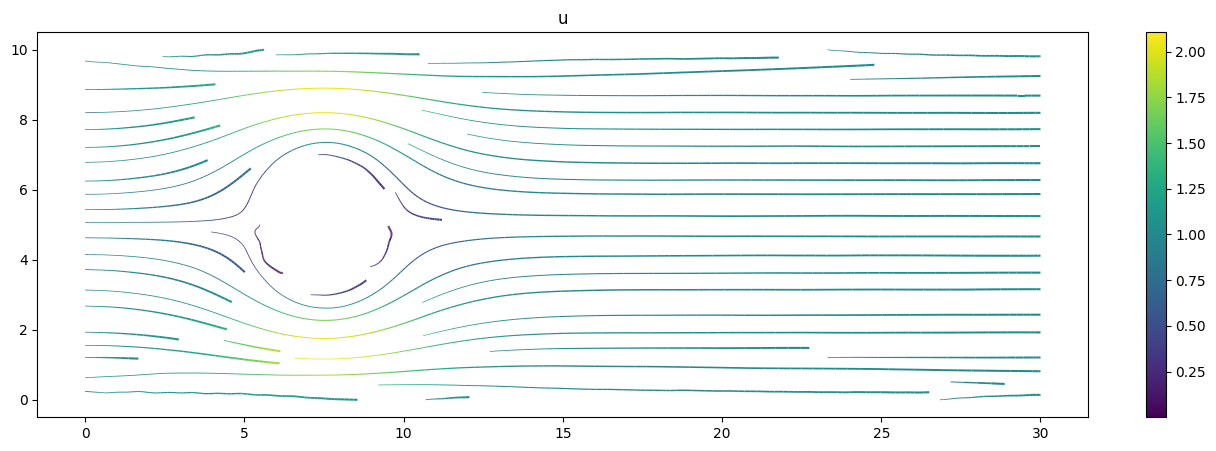

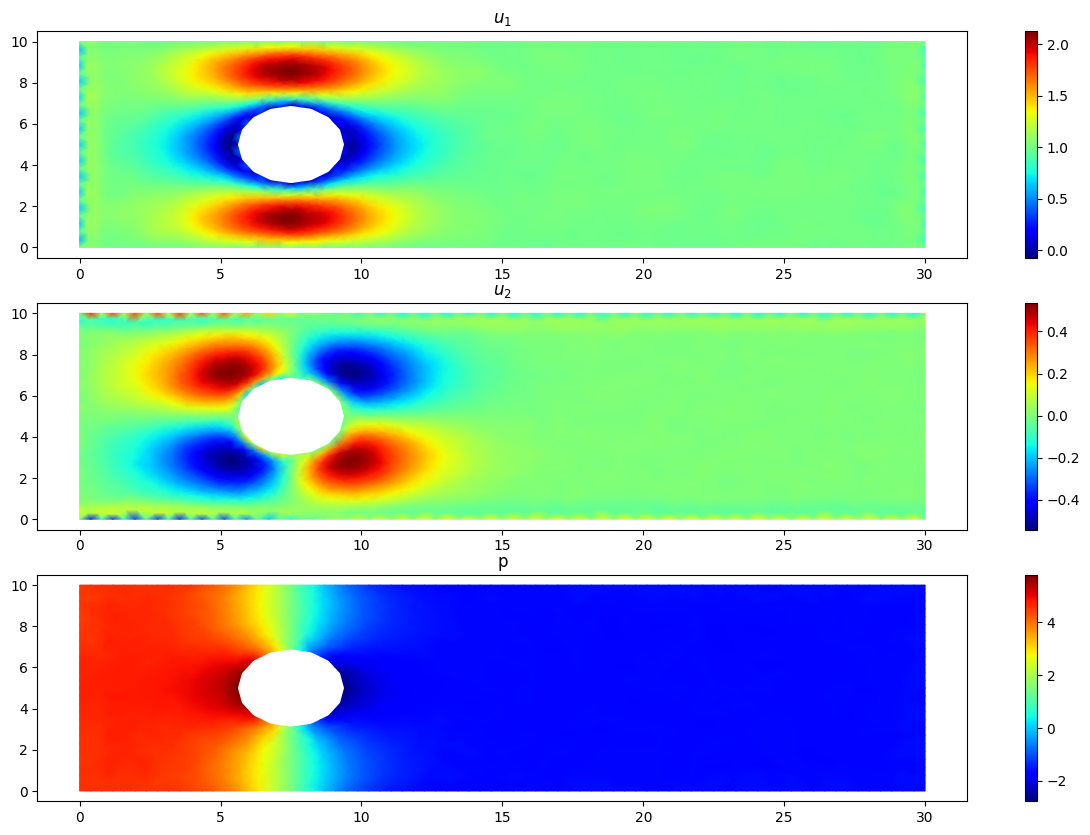

In [28]:
# Convert PyTorch tensor to Firedrake
sol_fd = from_torch(sol, Z)
# Plot
plot_sol(sol_fd)

### Exercise

We have previously used the residual to encode PDE-based signals in the loss function, i.e by considering the following loss:

$$
\begin{equation}
\mathcal{L} = \|sol - sol_{exact}\|_{\ell_{2}}^{2} + \alpha \|F(f, u)\|^{2}_{\ell_{2}}
\end{equation}
$$

Let's now try out a different loss function. In this exercise, we will remove the first term of the loss and only keep the residual norm. However, instead of returning the assembled residual, we will use the `torch_operator` interface (Bouziani & Ham, 2023), to compute the $L^{2}$ norm of the Riesz representer of the cofunction resulting from assembling the residual form, In other words, we want to use the following loss:

$$
\begin{equation}
\mathcal{L} = \|\mathcal{R}(F(f, u))\|^{2}_{L^{2}}
\end{equation}
$$

where $\mathcal{R}$ maps any cofunction on a dual space $V^{*}$ to its Riesz representer on $V$.

**Hint** : You can get the L2 Riesz representer of a cofunction by using ``.riesz_representation(riesz_map="L2")``

In [29]:
def loss_fn(f, sol, sol_exact, alpha):
  # Assemble residual
  residual = G(sol, f)
  # Compute the loss
  R = residual.riesz_representation(riesz_map="L2")
  loss = assemble(inner(R, R) * dx)
  return loss

In [30]:
sol = training(loss_fn)

AttributeError: 'Tensor' object has no attribute 'riesz_representation'